# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters , strides=strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    output_layer = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([output_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters, strides=1)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    layer_1 = encoder_block(inputs, 32, 2)
    layer_2 = encoder_block(layer_1, 64, 2)
    layer_3 = encoder_block(layer_2, 128, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    layer_4 = conv2d_batchnorm(layer_3, 256, kernel_size=1, strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    layer_5 = decoder_block(layer_4, layer_2, 128)
    layer_6 = decoder_block(layer_5, layer_1, 64)
    layer_7 = decoder_block(layer_6, inputs, 32)
    
    # The function returns the output layer of your model. "layer_5" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(layer_7)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.002
batch_size = 32
num_epochs = 100
steps_per_epoch = 200
validation_steps = 50
workers = 5

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 160, 3)   0                                            
____________________________________________________________________________________________________
separable_conv2d_keras_1 (Separa (None, 80, 80, 32)    155         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 80, 80, 32)    128         separable_conv2d_keras_1[0][0]   
____________________________________________________________________________________________________
separable_conv2d_keras_2 (Separa (None, 40, 40, 64)    2400        batch_normalization_1[0][0]      
___________________________________________________________________________________________

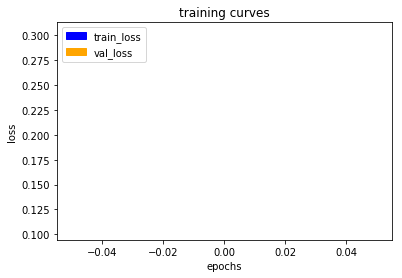

200/200 [==============================] - 57s - loss: 0.3020 - val_loss: 0.1045
Epoch 2/100
199/200 [============================>.] - ETA: 0s - loss: 0.0454

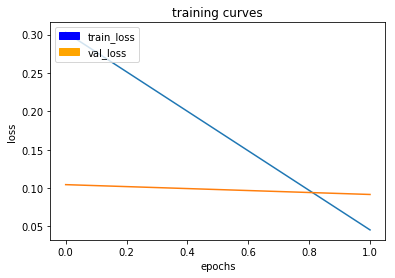

200/200 [==============================] - 55s - loss: 0.0454 - val_loss: 0.0917
Epoch 3/100
199/200 [============================>.] - ETA: 0s - loss: 0.0349

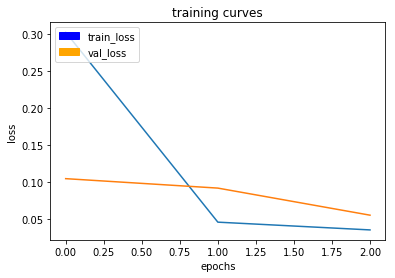

200/200 [==============================] - 56s - loss: 0.0350 - val_loss: 0.0549
Epoch 4/100
199/200 [============================>.] - ETA: 0s - loss: 0.0313

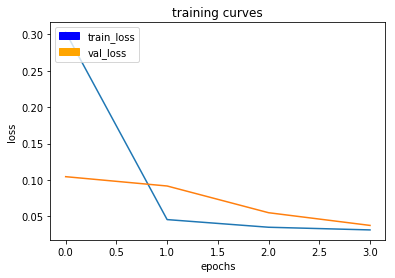

200/200 [==============================] - 55s - loss: 0.0313 - val_loss: 0.0375
Epoch 5/100
199/200 [============================>.] - ETA: 0s - loss: 0.0311

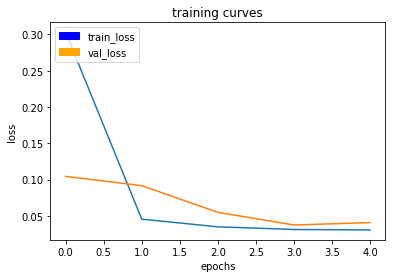

200/200 [==============================] - 55s - loss: 0.0310 - val_loss: 0.0408
Epoch 6/100
199/200 [============================>.] - ETA: 0s - loss: 0.0264

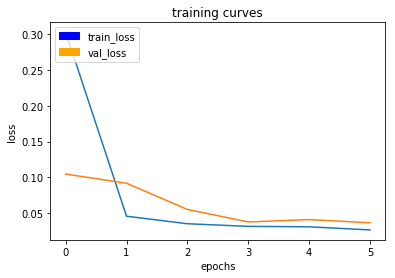

200/200 [==============================] - 54s - loss: 0.0263 - val_loss: 0.0363
Epoch 7/100
199/200 [============================>.] - ETA: 0s - loss: 0.0253

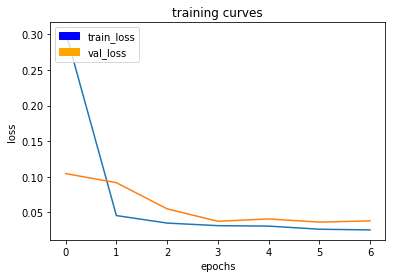

200/200 [==============================] - 55s - loss: 0.0253 - val_loss: 0.0380
Epoch 8/100
199/200 [============================>.] - ETA: 0s - loss: 0.0245

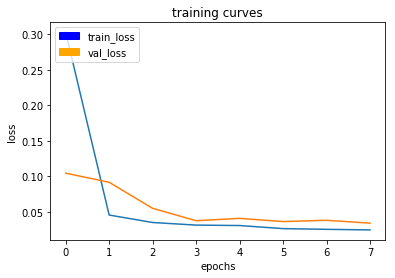

200/200 [==============================] - 56s - loss: 0.0245 - val_loss: 0.0341
Epoch 9/100
199/200 [============================>.] - ETA: 0s - loss: 0.0229

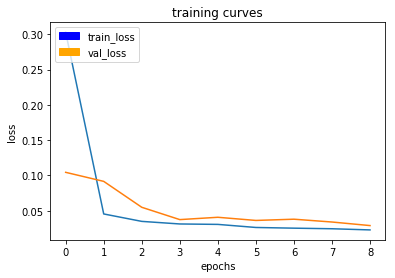

200/200 [==============================] - 56s - loss: 0.0229 - val_loss: 0.0290
Epoch 10/100
199/200 [============================>.] - ETA: 0s - loss: 0.0221

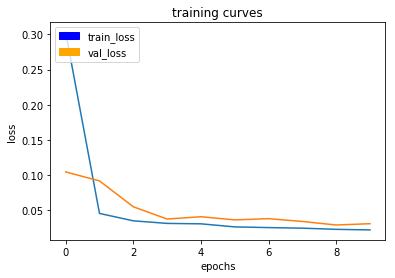

200/200 [==============================] - 56s - loss: 0.0221 - val_loss: 0.0309
Epoch 11/100
199/200 [============================>.] - ETA: 0s - loss: 0.0224

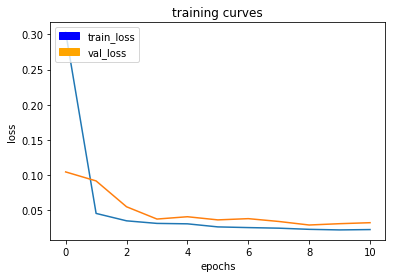

200/200 [==============================] - 55s - loss: 0.0226 - val_loss: 0.0323
Epoch 12/100
199/200 [============================>.] - ETA: 0s - loss: 0.0217

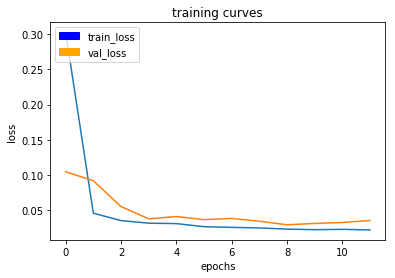

200/200 [==============================] - 54s - loss: 0.0217 - val_loss: 0.0351
Epoch 13/100
199/200 [============================>.] - ETA: 0s - loss: 0.0209

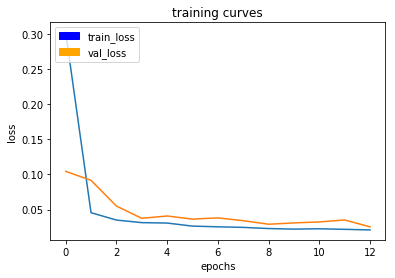

200/200 [==============================] - 55s - loss: 0.0209 - val_loss: 0.0252
Epoch 14/100
199/200 [============================>.] - ETA: 0s - loss: 0.0204

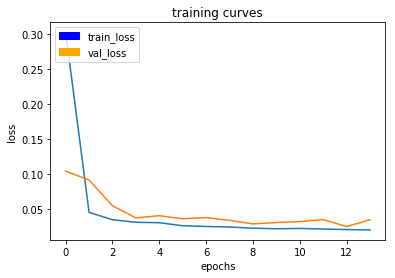

200/200 [==============================] - 56s - loss: 0.0203 - val_loss: 0.0349
Epoch 15/100
199/200 [============================>.] - ETA: 0s - loss: 0.0199

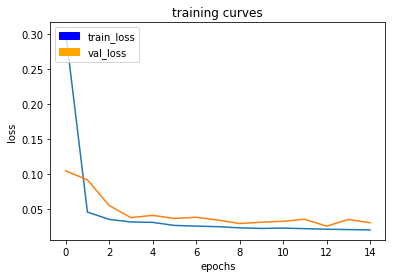

200/200 [==============================] - 55s - loss: 0.0199 - val_loss: 0.0302
Epoch 16/100
199/200 [============================>.] - ETA: 0s - loss: 0.0188

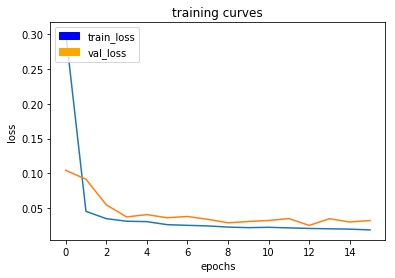

200/200 [==============================] - 55s - loss: 0.0188 - val_loss: 0.0323
Epoch 17/100
199/200 [============================>.] - ETA: 0s - loss: 0.0184

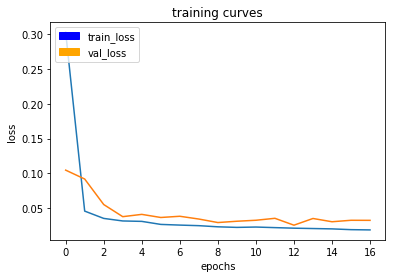

200/200 [==============================] - 56s - loss: 0.0183 - val_loss: 0.0322
Epoch 18/100
199/200 [============================>.] - ETA: 0s - loss: 0.0181

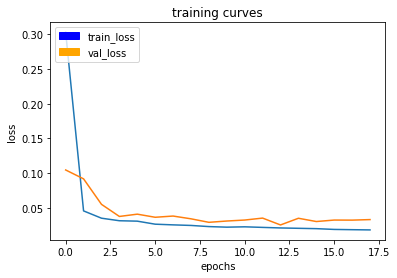

200/200 [==============================] - 55s - loss: 0.0181 - val_loss: 0.0329
Epoch 19/100
199/200 [============================>.] - ETA: 0s - loss: 0.0179

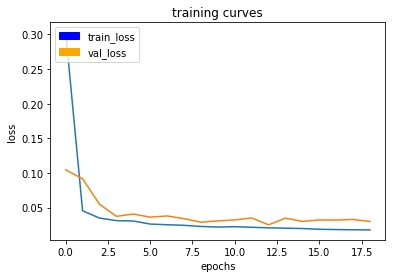

200/200 [==============================] - 55s - loss: 0.0179 - val_loss: 0.0300
Epoch 20/100
199/200 [============================>.] - ETA: 0s - loss: 0.0172

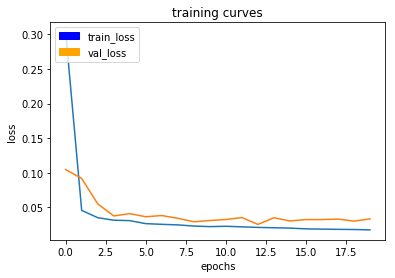

200/200 [==============================] - 55s - loss: 0.0173 - val_loss: 0.0332
Epoch 21/100
199/200 [============================>.] - ETA: 0s - loss: 0.0189

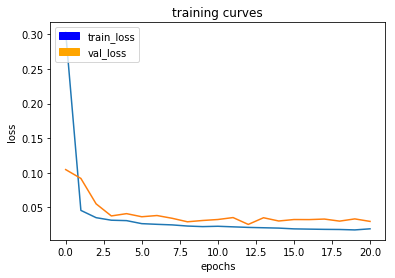

200/200 [==============================] - 54s - loss: 0.0189 - val_loss: 0.0296
Epoch 22/100
199/200 [============================>.] - ETA: 0s - loss: 0.0165

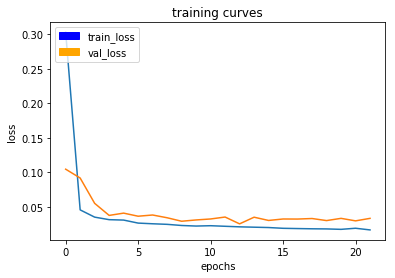

200/200 [==============================] - 55s - loss: 0.0165 - val_loss: 0.0332
Epoch 23/100
199/200 [============================>.] - ETA: 0s - loss: 0.0162

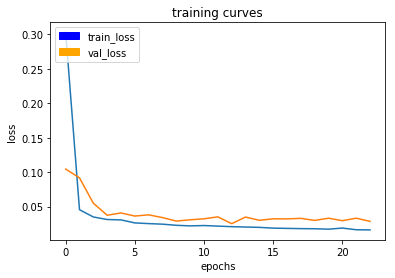

200/200 [==============================] - 55s - loss: 0.0162 - val_loss: 0.0286
Epoch 24/100
199/200 [============================>.] - ETA: 0s - loss: 0.0190

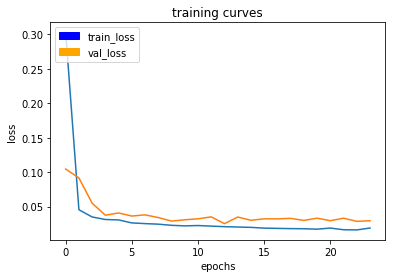

200/200 [==============================] - 58s - loss: 0.0190 - val_loss: 0.0295
Epoch 25/100
199/200 [============================>.] - ETA: 0s - loss: 0.0167

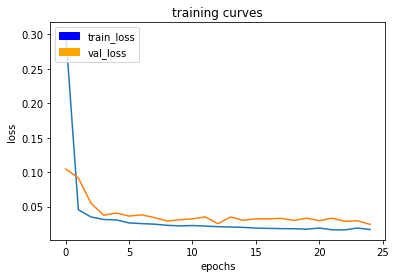

200/200 [==============================] - 56s - loss: 0.0168 - val_loss: 0.0242
Epoch 26/100
199/200 [============================>.] - ETA: 0s - loss: 0.0162

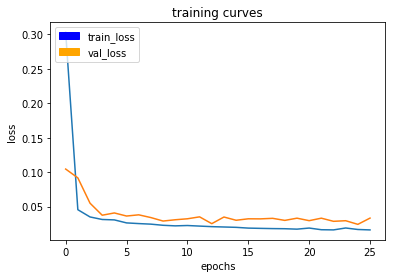

200/200 [==============================] - 56s - loss: 0.0162 - val_loss: 0.0333
Epoch 27/100
199/200 [============================>.] - ETA: 0s - loss: 0.0147

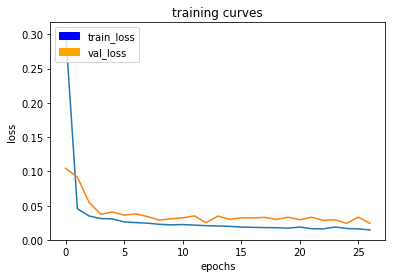

200/200 [==============================] - 55s - loss: 0.0147 - val_loss: 0.0242
Epoch 28/100
199/200 [============================>.] - ETA: 0s - loss: 0.0159

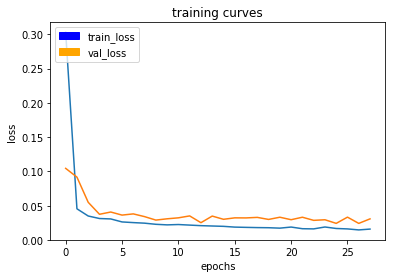

200/200 [==============================] - 54s - loss: 0.0159 - val_loss: 0.0308
Epoch 29/100
199/200 [============================>.] - ETA: 0s - loss: 0.0140

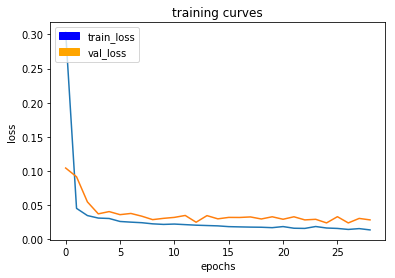

200/200 [==============================] - 55s - loss: 0.0140 - val_loss: 0.0286
Epoch 30/100
199/200 [============================>.] - ETA: 0s - loss: 0.0146

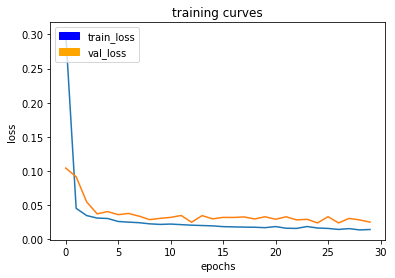

200/200 [==============================] - 55s - loss: 0.0146 - val_loss: 0.0254
Epoch 31/100
199/200 [============================>.] - ETA: 0s - loss: 0.0157

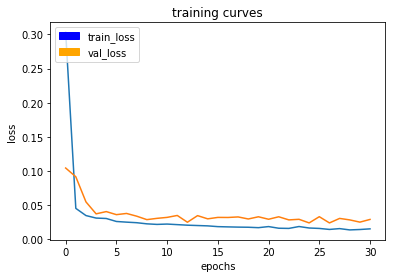

200/200 [==============================] - 55s - loss: 0.0157 - val_loss: 0.0293
Epoch 32/100
199/200 [============================>.] - ETA: 0s - loss: 0.0152

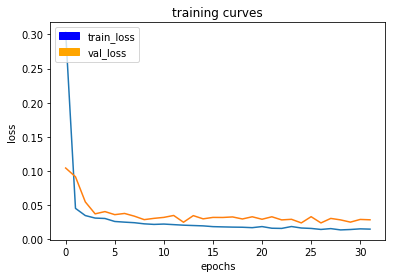

200/200 [==============================] - 55s - loss: 0.0152 - val_loss: 0.0288
Epoch 33/100
199/200 [============================>.] - ETA: 0s - loss: 0.0144

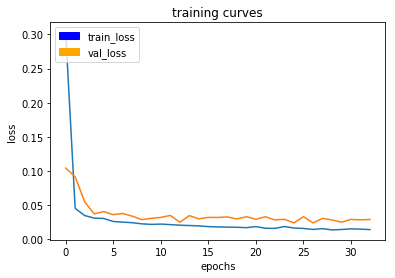

200/200 [==============================] - 56s - loss: 0.0144 - val_loss: 0.0292
Epoch 34/100
199/200 [============================>.] - ETA: 0s - loss: 0.0143

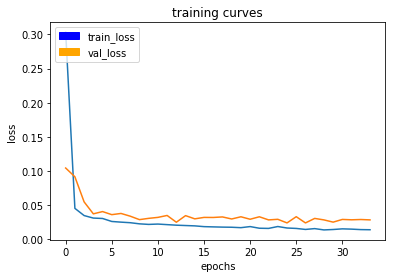

200/200 [==============================] - 55s - loss: 0.0142 - val_loss: 0.0286
Epoch 35/100
199/200 [============================>.] - ETA: 0s - loss: 0.0164

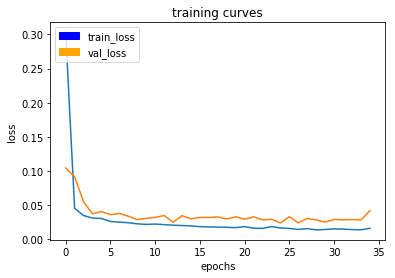

200/200 [==============================] - 54s - loss: 0.0164 - val_loss: 0.0422
Epoch 36/100
199/200 [============================>.] - ETA: 0s - loss: 0.0170

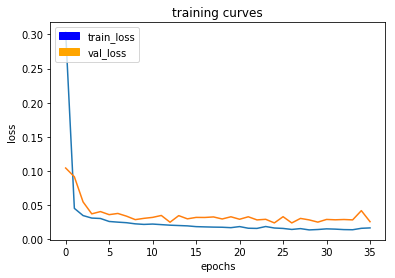

200/200 [==============================] - 54s - loss: 0.0170 - val_loss: 0.0260
Epoch 37/100
199/200 [============================>.] - ETA: 0s - loss: 0.0134

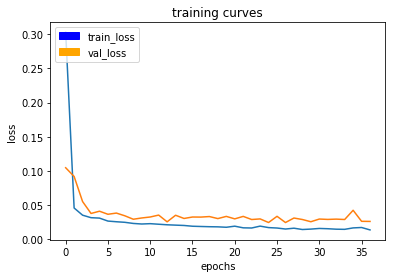

200/200 [==============================] - 55s - loss: 0.0134 - val_loss: 0.0258
Epoch 38/100
199/200 [============================>.] - ETA: 0s - loss: 0.0134

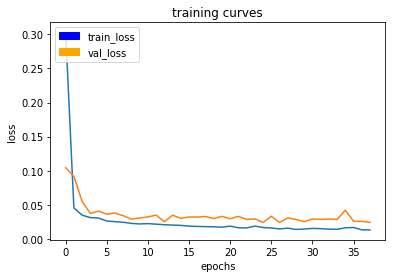

200/200 [==============================] - 54s - loss: 0.0134 - val_loss: 0.0243
Epoch 39/100
199/200 [============================>.] - ETA: 0s - loss: 0.0133

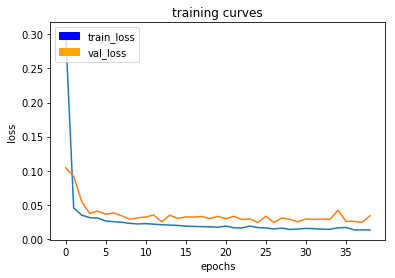

200/200 [==============================] - 55s - loss: 0.0133 - val_loss: 0.0340
Epoch 40/100
199/200 [============================>.] - ETA: 0s - loss: 0.0144

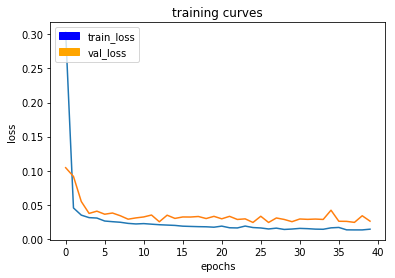

200/200 [==============================] - 55s - loss: 0.0144 - val_loss: 0.0261
Epoch 41/100
199/200 [============================>.] - ETA: 0s - loss: 0.0207

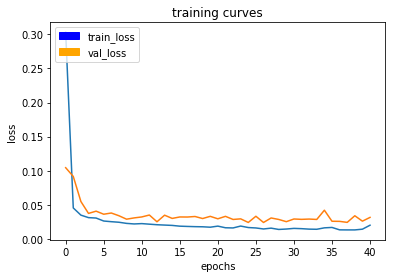

200/200 [==============================] - 54s - loss: 0.0207 - val_loss: 0.0316
Epoch 42/100
199/200 [============================>.] - ETA: 0s - loss: 0.0156

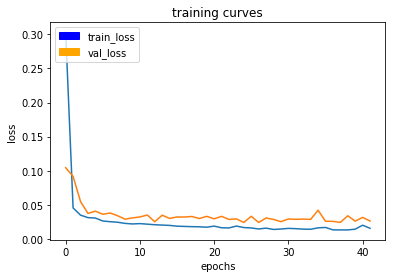

200/200 [==============================] - 55s - loss: 0.0156 - val_loss: 0.0263
Epoch 43/100
199/200 [============================>.] - ETA: 0s - loss: 0.0137

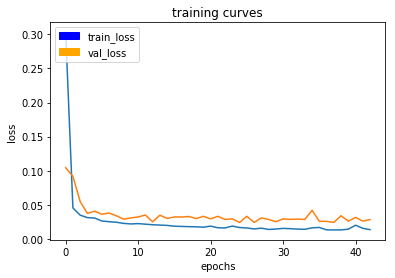

200/200 [==============================] - 54s - loss: 0.0137 - val_loss: 0.0284
Epoch 44/100
199/200 [============================>.] - ETA: 0s - loss: 0.0127

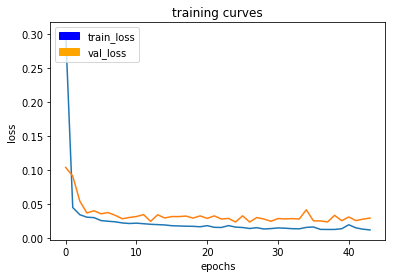

200/200 [==============================] - 54s - loss: 0.0127 - val_loss: 0.0300
Epoch 45/100
199/200 [============================>.] - ETA: 0s - loss: 0.0122

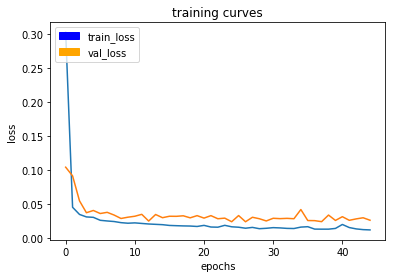

200/200 [==============================] - 54s - loss: 0.0122 - val_loss: 0.0264
Epoch 46/100
199/200 [============================>.] - ETA: 0s - loss: 0.0129

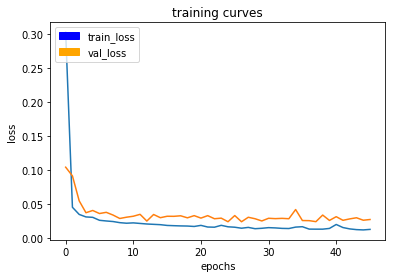

200/200 [==============================] - 54s - loss: 0.0129 - val_loss: 0.0275
Epoch 47/100
199/200 [============================>.] - ETA: 0s - loss: 0.0141

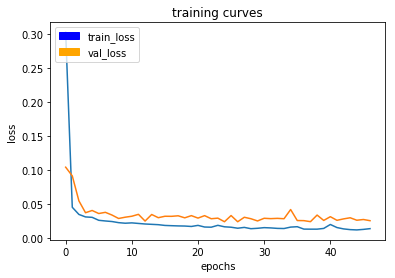

200/200 [==============================] - 54s - loss: 0.0141 - val_loss: 0.0258
Epoch 48/100
199/200 [============================>.] - ETA: 0s - loss: 0.0121

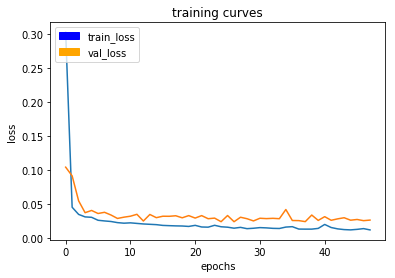

200/200 [==============================] - 55s - loss: 0.0121 - val_loss: 0.0266
Epoch 49/100
199/200 [============================>.] - ETA: 0s - loss: 0.0129

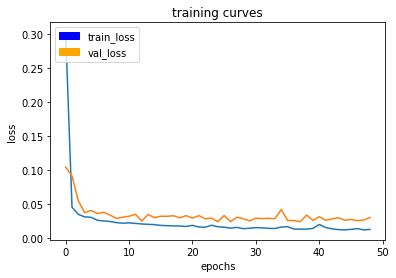

200/200 [==============================] - 54s - loss: 0.0129 - val_loss: 0.0304
Epoch 50/100
199/200 [============================>.] - ETA: 0s - loss: 0.0166

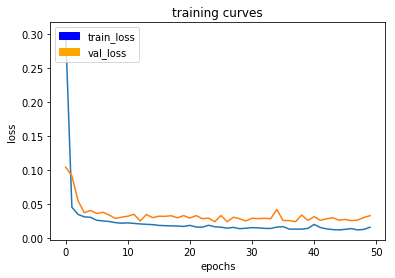

200/200 [==============================] - 54s - loss: 0.0166 - val_loss: 0.0331
Epoch 51/100
199/200 [============================>.] - ETA: 0s - loss: 0.0225

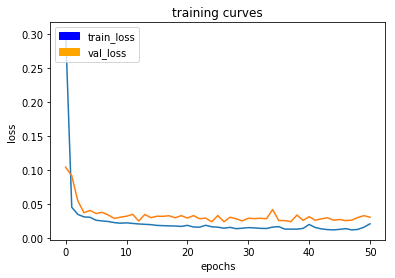

200/200 [==============================] - 54s - loss: 0.0224 - val_loss: 0.0307
Epoch 52/100
199/200 [============================>.] - ETA: 0s - loss: 0.0138

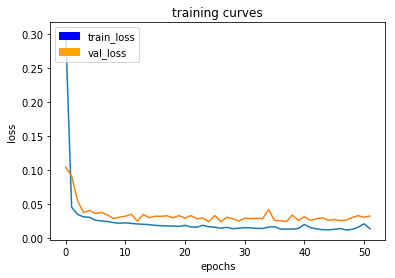

200/200 [==============================] - 54s - loss: 0.0138 - val_loss: 0.0325
Epoch 53/100
199/200 [============================>.] - ETA: 0s - loss: 0.0133

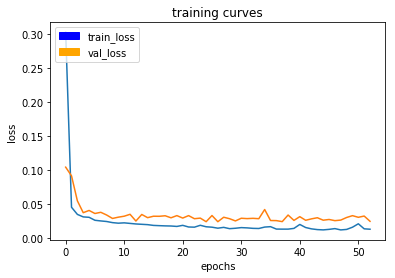

200/200 [==============================] - 55s - loss: 0.0132 - val_loss: 0.0248
Epoch 54/100
199/200 [============================>.] - ETA: 0s - loss: 0.0122

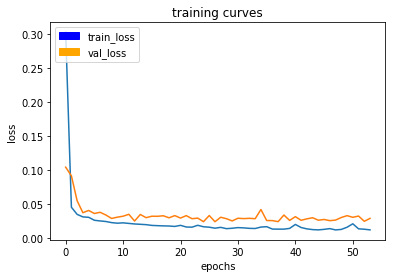

200/200 [==============================] - 54s - loss: 0.0122 - val_loss: 0.0291
Epoch 55/100
199/200 [============================>.] - ETA: 0s - loss: 0.0122

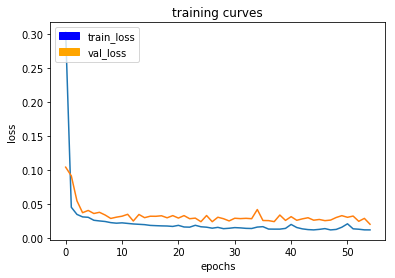

200/200 [==============================] - 55s - loss: 0.0122 - val_loss: 0.0204
Epoch 56/100
199/200 [============================>.] - ETA: 0s - loss: 0.0138

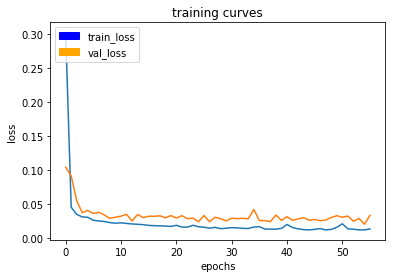

200/200 [==============================] - 54s - loss: 0.0137 - val_loss: 0.0337
Epoch 57/100
199/200 [============================>.] - ETA: 0s - loss: 0.0131

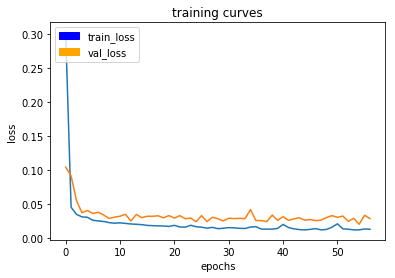

200/200 [==============================] - 55s - loss: 0.0131 - val_loss: 0.0287
Epoch 58/100
199/200 [============================>.] - ETA: 0s - loss: 0.0118

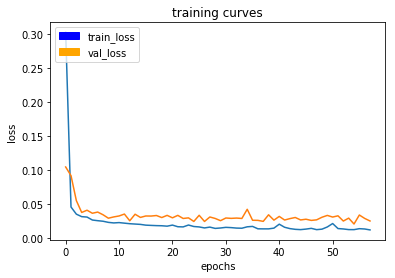

200/200 [==============================] - 54s - loss: 0.0118 - val_loss: 0.0249
Epoch 59/100
199/200 [============================>.] - ETA: 0s - loss: 0.0116

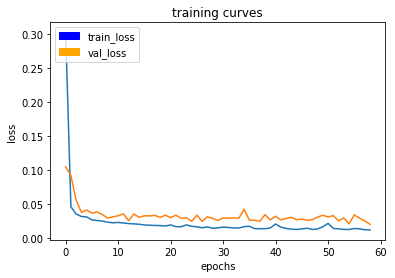

200/200 [==============================] - 55s - loss: 0.0115 - val_loss: 0.0197
Epoch 60/100
199/200 [============================>.] - ETA: 0s - loss: 0.0120

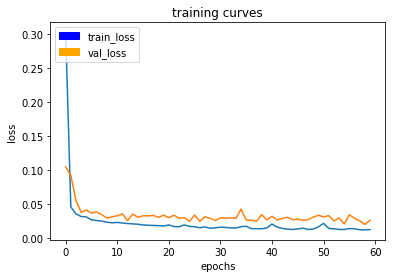

200/200 [==============================] - 54s - loss: 0.0120 - val_loss: 0.0257
Epoch 61/100
199/200 [============================>.] - ETA: 0s - loss: 0.0115

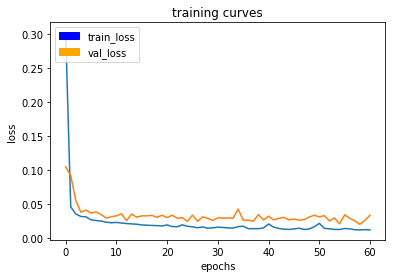

200/200 [==============================] - 55s - loss: 0.0115 - val_loss: 0.0332
Epoch 62/100
199/200 [============================>.] - ETA: 0s - loss: 0.0125

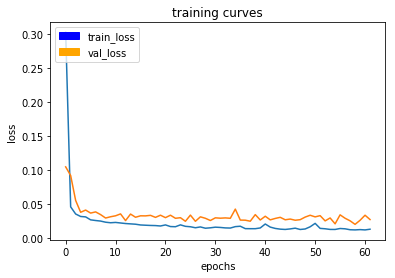

200/200 [==============================] - 54s - loss: 0.0125 - val_loss: 0.0268
Epoch 63/100
199/200 [============================>.] - ETA: 0s - loss: 0.0129

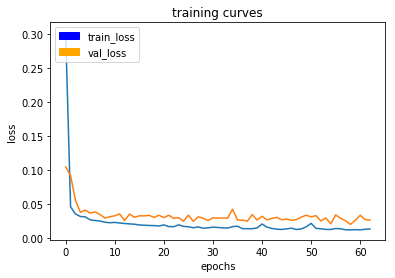

200/200 [==============================] - 55s - loss: 0.0129 - val_loss: 0.0259
Epoch 64/100
199/200 [============================>.] - ETA: 0s - loss: 0.0109

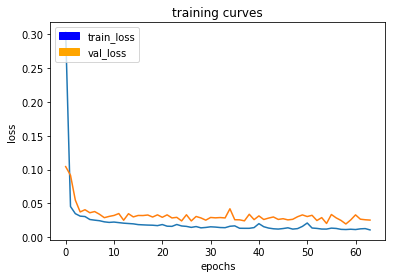

200/200 [==============================] - 54s - loss: 0.0109 - val_loss: 0.0254
Epoch 65/100
199/200 [============================>.] - ETA: 0s - loss: 0.0136

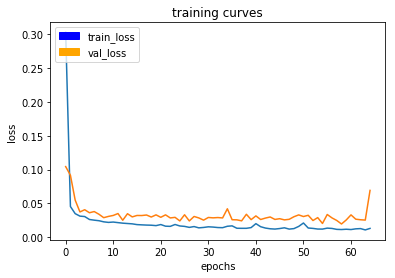

200/200 [==============================] - 54s - loss: 0.0136 - val_loss: 0.0693
Epoch 66/100
199/200 [============================>.] - ETA: 0s - loss: 0.0139

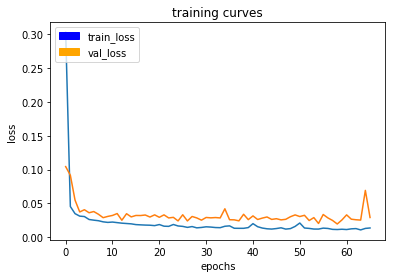

200/200 [==============================] - 54s - loss: 0.0138 - val_loss: 0.0293
Epoch 67/100
199/200 [============================>.] - ETA: 0s - loss: 0.0117

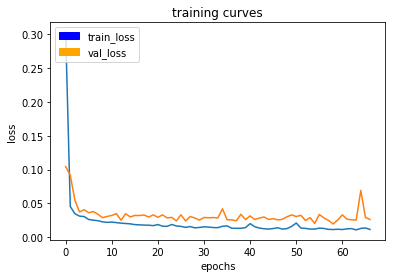

200/200 [==============================] - 55s - loss: 0.0117 - val_loss: 0.0264
Epoch 68/100
199/200 [============================>.] - ETA: 0s - loss: 0.0114

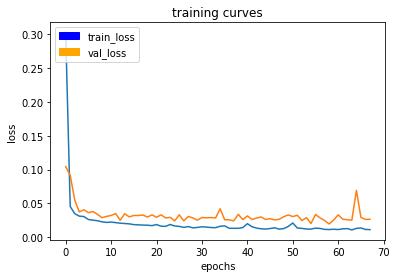

200/200 [==============================] - 54s - loss: 0.0114 - val_loss: 0.0267
Epoch 69/100
199/200 [============================>.] - ETA: 0s - loss: 0.0109

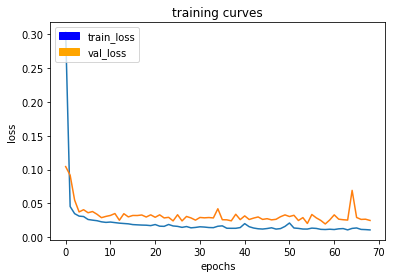

200/200 [==============================] - 54s - loss: 0.0109 - val_loss: 0.0249
Epoch 70/100
199/200 [============================>.] - ETA: 0s - loss: 0.0107

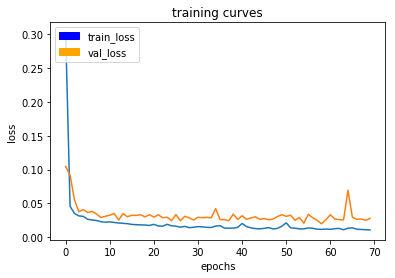

200/200 [==============================] - 54s - loss: 0.0107 - val_loss: 0.0277
Epoch 71/100
199/200 [============================>.] - ETA: 0s - loss: 0.0125

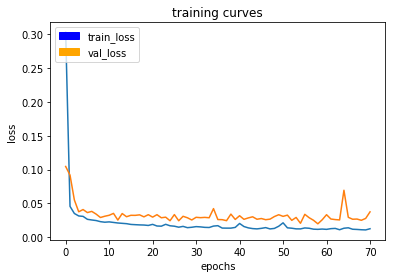

200/200 [==============================] - 54s - loss: 0.0125 - val_loss: 0.0373
Epoch 72/100
199/200 [============================>.] - ETA: 0s - loss: 0.0116

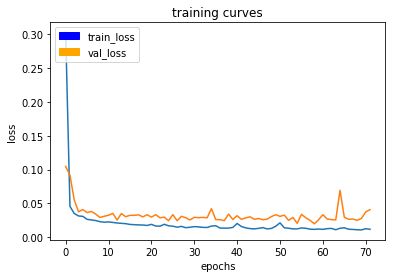

200/200 [==============================] - 54s - loss: 0.0116 - val_loss: 0.0406
Epoch 73/100
199/200 [============================>.] - ETA: 0s - loss: 0.0149

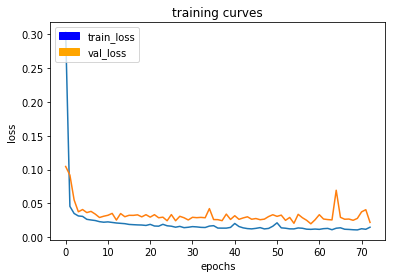

200/200 [==============================] - 54s - loss: 0.0149 - val_loss: 0.0217
Epoch 74/100
199/200 [============================>.] - ETA: 0s - loss: 0.0118

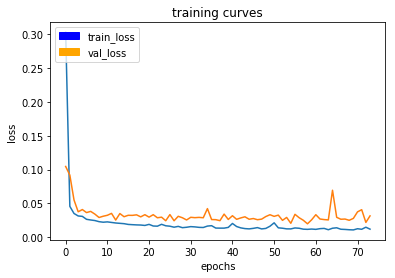

200/200 [==============================] - 54s - loss: 0.0118 - val_loss: 0.0314
Epoch 75/100
199/200 [============================>.] - ETA: 0s - loss: 0.0119

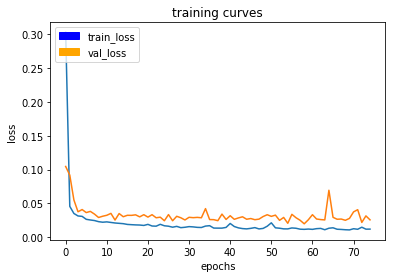

200/200 [==============================] - 54s - loss: 0.0118 - val_loss: 0.0255
Epoch 76/100
199/200 [============================>.] - ETA: 0s - loss: 0.0111

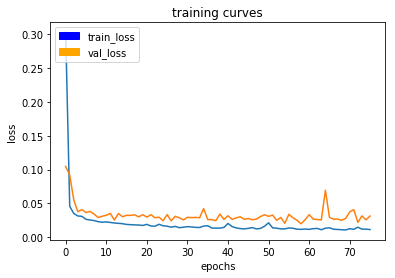

200/200 [==============================] - 55s - loss: 0.0111 - val_loss: 0.0312
Epoch 77/100
199/200 [============================>.] - ETA: 0s - loss: 0.0105

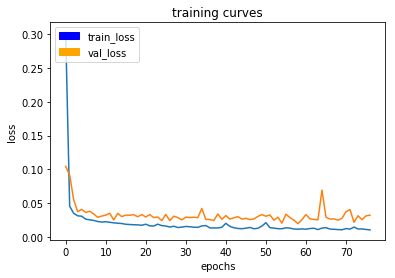

200/200 [==============================] - 54s - loss: 0.0105 - val_loss: 0.0323
Epoch 78/100
199/200 [============================>.] - ETA: 0s - loss: 0.0103

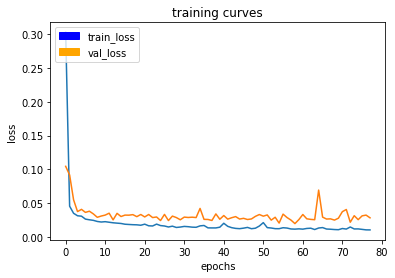

200/200 [==============================] - 54s - loss: 0.0103 - val_loss: 0.0282
Epoch 79/100
199/200 [============================>.] - ETA: 0s - loss: 0.0101

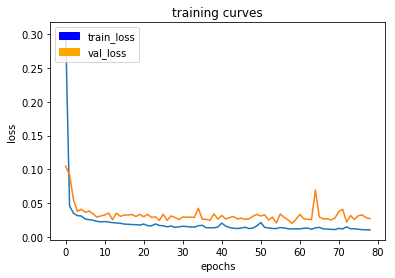

200/200 [==============================] - 54s - loss: 0.0101 - val_loss: 0.0267
Epoch 80/100
199/200 [============================>.] - ETA: 0s - loss: 0.0103

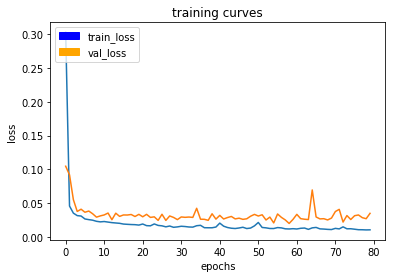

200/200 [==============================] - 55s - loss: 0.0103 - val_loss: 0.0347
Epoch 81/100
199/200 [============================>.] - ETA: 0s - loss: 0.0100

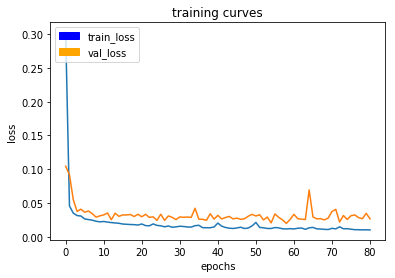

200/200 [==============================] - 54s - loss: 0.0101 - val_loss: 0.0264
Epoch 82/100
199/200 [============================>.] - ETA: 0s - loss: 0.0108

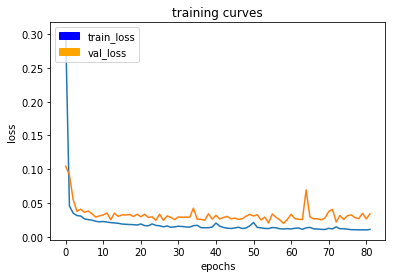

200/200 [==============================] - 54s - loss: 0.0108 - val_loss: 0.0339
Epoch 83/100
199/200 [============================>.] - ETA: 0s - loss: 0.0137

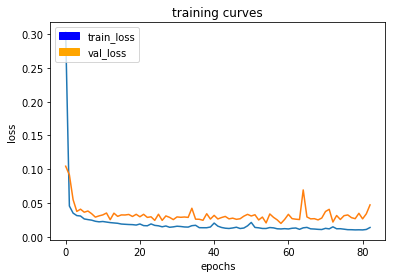

200/200 [==============================] - 54s - loss: 0.0137 - val_loss: 0.0471
Epoch 84/100
199/200 [============================>.] - ETA: 0s - loss: 0.0116

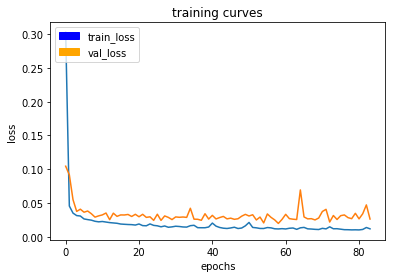

200/200 [==============================] - 54s - loss: 0.0117 - val_loss: 0.0262
Epoch 85/100
199/200 [============================>.] - ETA: 0s - loss: 0.0105

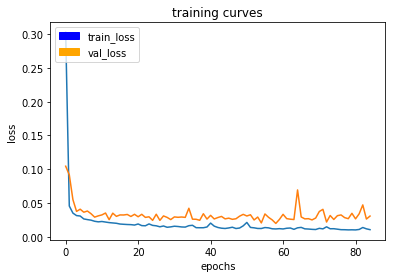

200/200 [==============================] - 54s - loss: 0.0105 - val_loss: 0.0306
Epoch 86/100
199/200 [============================>.] - ETA: 0s - loss: 0.0102

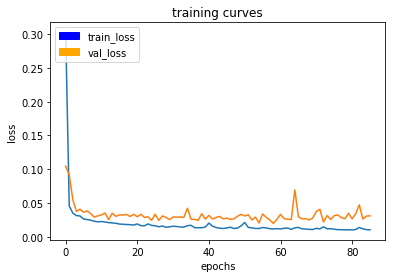

200/200 [==============================] - 54s - loss: 0.0102 - val_loss: 0.0309
Epoch 87/100
199/200 [============================>.] - ETA: 0s - loss: 0.0103

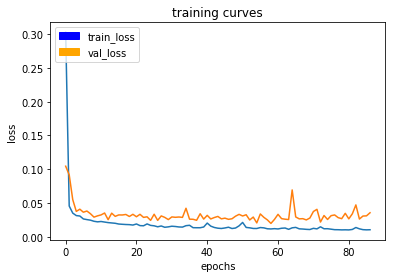

200/200 [==============================] - 54s - loss: 0.0103 - val_loss: 0.0355
Epoch 88/100
199/200 [============================>.] - ETA: 0s - loss: 0.0102

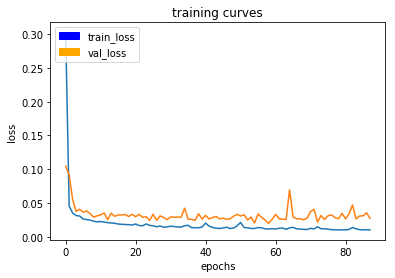

200/200 [==============================] - 54s - loss: 0.0102 - val_loss: 0.0270
Epoch 89/100
199/200 [============================>.] - ETA: 0s - loss: 0.0101

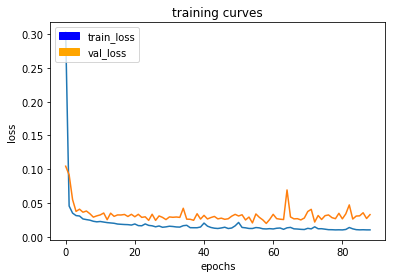

200/200 [==============================] - 55s - loss: 0.0101 - val_loss: 0.0327
Epoch 90/100
199/200 [============================>.] - ETA: 0s - loss: 0.0099

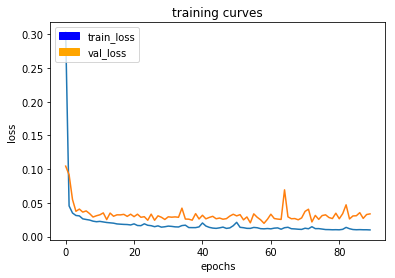

200/200 [==============================] - 54s - loss: 0.0099 - val_loss: 0.0337
Epoch 91/100
199/200 [============================>.] - ETA: 0s - loss: 0.0099

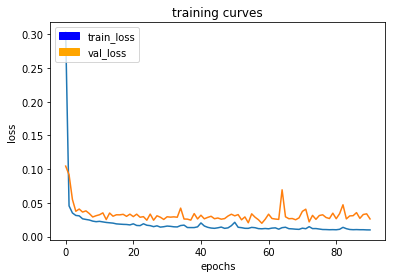

200/200 [==============================] - 54s - loss: 0.0099 - val_loss: 0.0261
Epoch 92/100
199/200 [============================>.] - ETA: 0s - loss: 0.0140

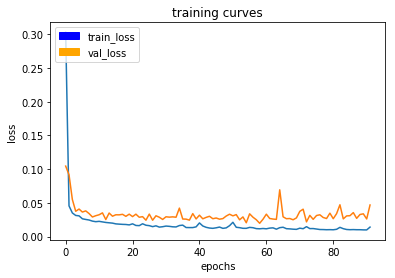

200/200 [==============================] - 54s - loss: 0.0140 - val_loss: 0.0468
Epoch 93/100
199/200 [============================>.] - ETA: 0s - loss: 0.0133

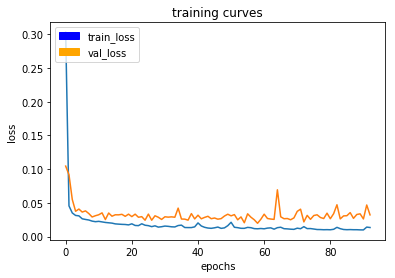

200/200 [==============================] - 54s - loss: 0.0133 - val_loss: 0.0321
Epoch 94/100
199/200 [============================>.] - ETA: 0s - loss: 0.0105

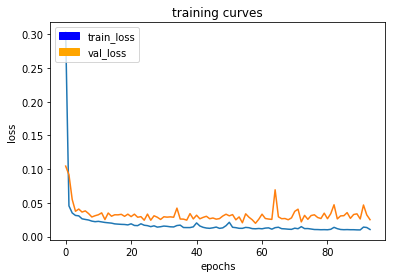

200/200 [==============================] - 54s - loss: 0.0105 - val_loss: 0.0250
Epoch 95/100
199/200 [============================>.] - ETA: 0s - loss: 0.0102

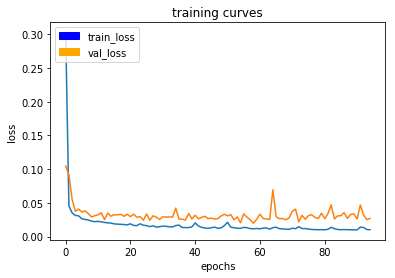

200/200 [==============================] - 54s - loss: 0.0102 - val_loss: 0.0270
Epoch 96/100
199/200 [============================>.] - ETA: 0s - loss: 0.0097

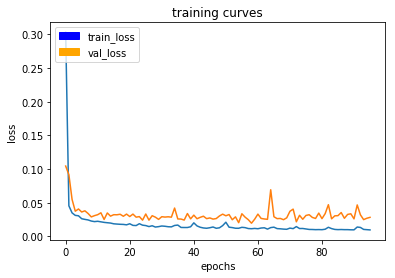

200/200 [==============================] - 54s - loss: 0.0097 - val_loss: 0.0284
Epoch 97/100
199/200 [============================>.] - ETA: 0s - loss: 0.0096

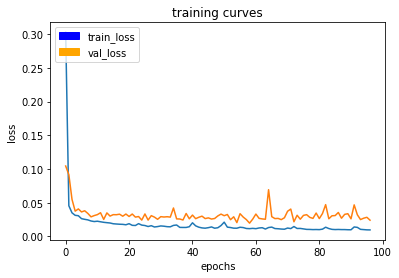

200/200 [==============================] - 54s - loss: 0.0096 - val_loss: 0.0241
Epoch 98/100
199/200 [============================>.] - ETA: 0s - loss: 0.0101

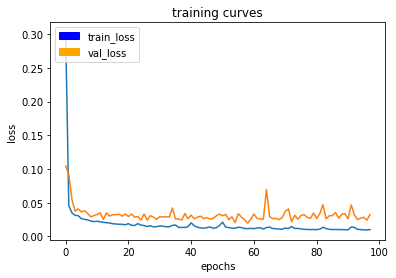

200/200 [==============================] - 54s - loss: 0.0101 - val_loss: 0.0325
Epoch 99/100
199/200 [============================>.] - ETA: 0s - loss: 0.0103

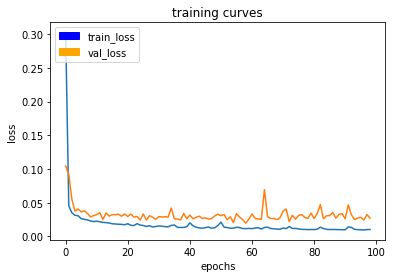

200/200 [==============================] - 54s - loss: 0.0103 - val_loss: 0.0271
Epoch 100/100
199/200 [============================>.] - ETA: 0s - loss: 0.0098

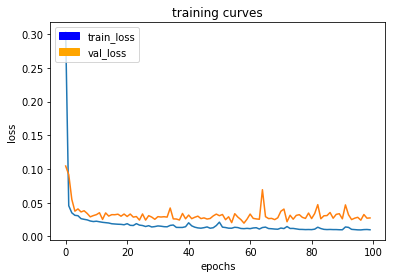

200/200 [==============================] - 55s - loss: 0.0098 - val_loss: 0.0274


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

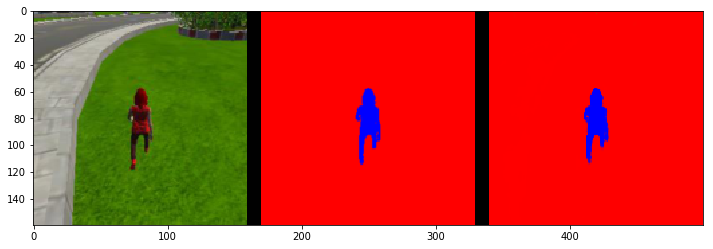

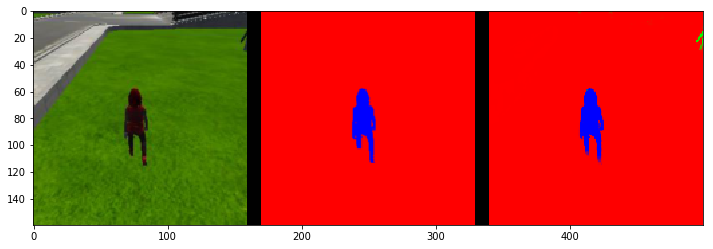

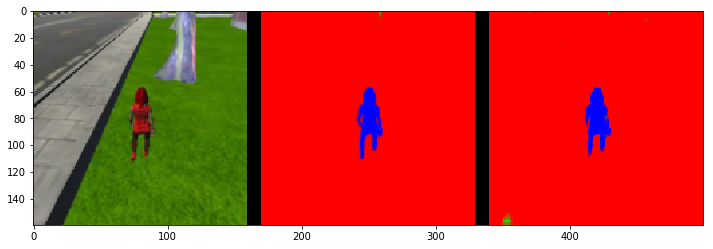

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

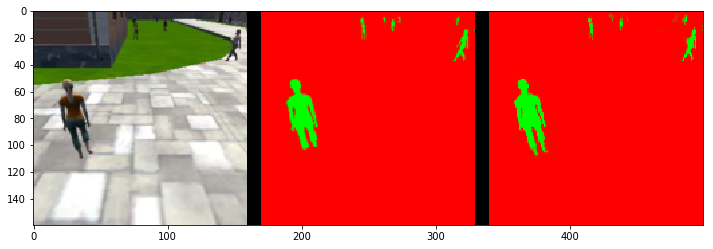

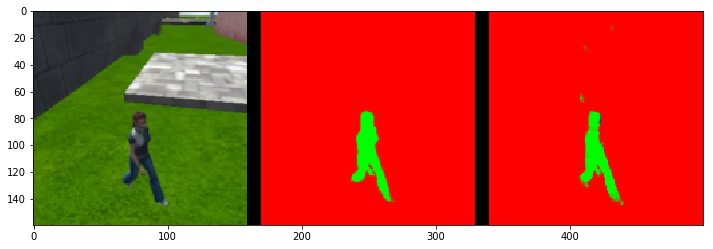

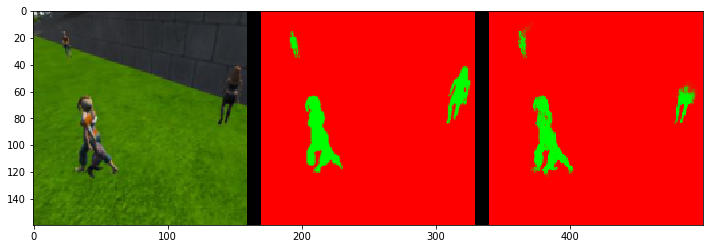

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

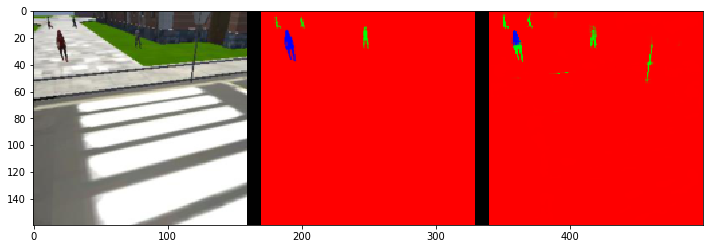

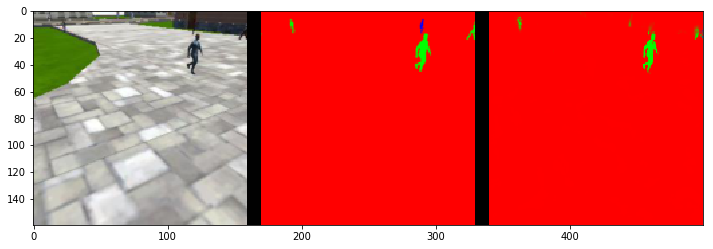

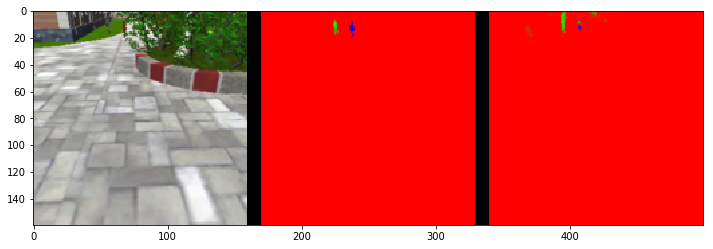

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.995990646239
average intersection over union for other people is 0.36794329476
average intersection over union for the hero is 0.916386351051
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.986185149222
average intersection over union for other people is 0.718848343485
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 63, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.996499004335
average intersection over union for other people is 0.453317615995
average intersection over union for the hero is 0.215140560149
number true positives: 124, number false positives: 2, number false negatives: 177


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = float(true_pos)/(true_pos+false_neg+false_pos)
print(weight)

0.732596685083


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.5657634556


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.414476432114
